# 보령댐 시간별 데이터 분석

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np # linear algebra
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import math
from datetime import datetime, date 
import warnings
warnings.filterwarnings('ignore')

print("Setup Complete")

Setup Complete


## EDA

### Import Data

In [2]:
chungju_hr_df = pd.read_csv('./data/다목적댐 데이터/보령댐_시간별.csv', encoding= 'cp949', thousands=',')
chungju_hr_df.head()

,일시,댐수위(ELm),강우량(mm),유입량(㎡/sec),총방류량(㎡/sec),저수량(백만㎥/sec),저수율(%)
0,2015-01-01 01시,66.12,0.0,2.6,2.6,53.0,45.3
1,2015-01-01 02시,66.12,0.0,3.0,3.0,53.0,45.3
2,2015-01-01 03시,66.12,0.0,3.1,3.1,53.0,45.3
3,2015-01-01 04시,66.12,0.0,3.0,3.0,53.0,45.3
4,2015-01-01 05시,66.12,0.0,2.9,2.9,53.0,45.3


In [3]:
chungju_hr_df.columns = ['date', 'water_level', 'rainfall', 'inflow', 'outflow', 'reserve', 'reserve_rate']

all_cols = ['date', 'water_level', 'rainfall', 'inflow', 'outflow', 'reserve', 'reserve_rate']
feature_cols = ['rainfall', 'inflow', 'outflow', 'reserve_rate']
chungju_hr_df.head()

,date,water_level,rainfall,inflow,outflow,reserve,reserve_rate
0,2015-01-01 01시,66.12,0.0,2.6,2.6,53.0,45.3
1,2015-01-01 02시,66.12,0.0,3.0,3.0,53.0,45.3
2,2015-01-01 03시,66.12,0.0,3.1,3.1,53.0,45.3
3,2015-01-01 04시,66.12,0.0,3.0,3.0,53.0,45.3
4,2015-01-01 05시,66.12,0.0,2.9,2.9,53.0,45.3


#### Datetime에 맞도록 형태 변환

In [4]:
# ~시 -> ~:00으로 바꿔야 함, 24:00 -> 다음날 00:00으로 바꿔야 함
chungju_hr_df['date'] = chungju_hr_df['date'].str.replace('시', ':00')
data = chungju_hr_df['date']
print(data)


0        2015-01-01 01:00 
1        2015-01-01 02:00 
2        2015-01-01 03:00 
3        2015-01-01 04:00 
4        2015-01-01 05:00 
               ...        
74932    2023-07-20 06:00 
74933    2023-07-20 07:00 
74934    2023-07-20 08:00 
74935    2023-07-20 09:00 
74936    2023-07-20 10:00 
Name: date, Length: 74937, dtype: object


In [5]:
def convert(value):
    return str(value)

str_data = data.apply(convert)

changed_index = []
new_date = [] # 가공해서 넣을 date column list 

# 시간 값이 24인 경우를 00:00:00으로 변경, 날짜 하루 더해줌. 
for date in str_data:
    if " 24:" in date:
        temp = date.replace(" 24:", " 00:")
        new_date.append(pd.to_datetime(temp)+dt.timedelta(days=1))
    else: new_date.append(pd.to_datetime(date))

print(new_date[23]) # 2015-01-02 00:00:00
chungju_hr_df["date"] = new_date
chungju_hr_df.head()

2015-01-02 00:00:00


,date,water_level,rainfall,inflow,outflow,reserve,reserve_rate
0,2015-01-01 01:00:00,66.12,0.0,2.6,2.6,53.0,45.3
1,2015-01-01 02:00:00,66.12,0.0,3.0,3.0,53.0,45.3
2,2015-01-01 03:00:00,66.12,0.0,3.1,3.1,53.0,45.3
3,2015-01-01 04:00:00,66.12,0.0,3.0,3.0,53.0,45.3
4,2015-01-01 05:00:00,66.12,0.0,2.9,2.9,53.0,45.3


In [6]:
# 결측값 확인

print(chungju_hr_df.isnull().sum())
raw_df = chungju_hr_df.dropna(axis=0)
print(chungju_hr_df.isnull().sum())

date            0
water_level     0
rainfall        8
inflow          0
outflow         0
reserve         0
reserve_rate    0
dtype: int64
date            0
water_level     0
rainfall        8
inflow          0
outflow         0
reserve         0
reserve_rate    0
dtype: int64


In [7]:
chungju_hr_df.describe()

,water_level,rainfall,inflow,outflow,reserve,reserve_rate
count,74937.000000,74929.000000,74937.000000,74937.000000,74937.000000,74937.000000
mean,63.834850,0.156082,4.809672,3.879728,44.492453,38.064314
std,4.467609,1.159635,19.230348,12.237647,17.338853,14.832148
min,52.160000,0.000000,0.000000,0.000000,9.690000,8.300000
25%,61.080000,0.000000,2.000000,2.700000,32.850000,28.100000
50%,63.130000,0.000000,2.800000,3.100000,40.300000,34.500000
75%,65.910000,0.000000,3.300000,3.400000,51.890000,44.400000
max,74.510000,59.400000,1208.200000,648.800000,91.060000,77.900000


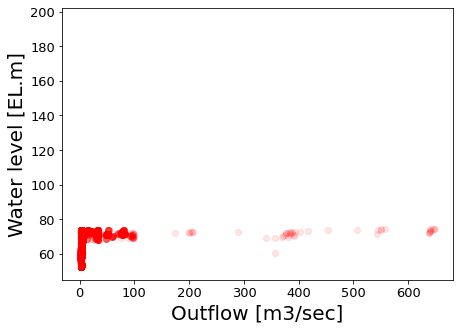

In [8]:
# data 간의 상관관계 분석 
# plot, 필요에 따라 correlation 을 추출할 수도 있음

plt.figure(figsize=(7,5))
y= raw_df['water_level']
x= raw_df['outflow']
plt.plot(70,195)
plt.plot(x,y, 'ro', alpha = 0.1)
plt.xlabel('Outflow [m3/sec]', fontsize = 20)
plt.ylabel('Water level [EL.m]', fontsize = 20)
plt.xlim
plt.ylim
plt.xticks(fontsize =13)
plt.yticks(fontsize =13)
plt.show()

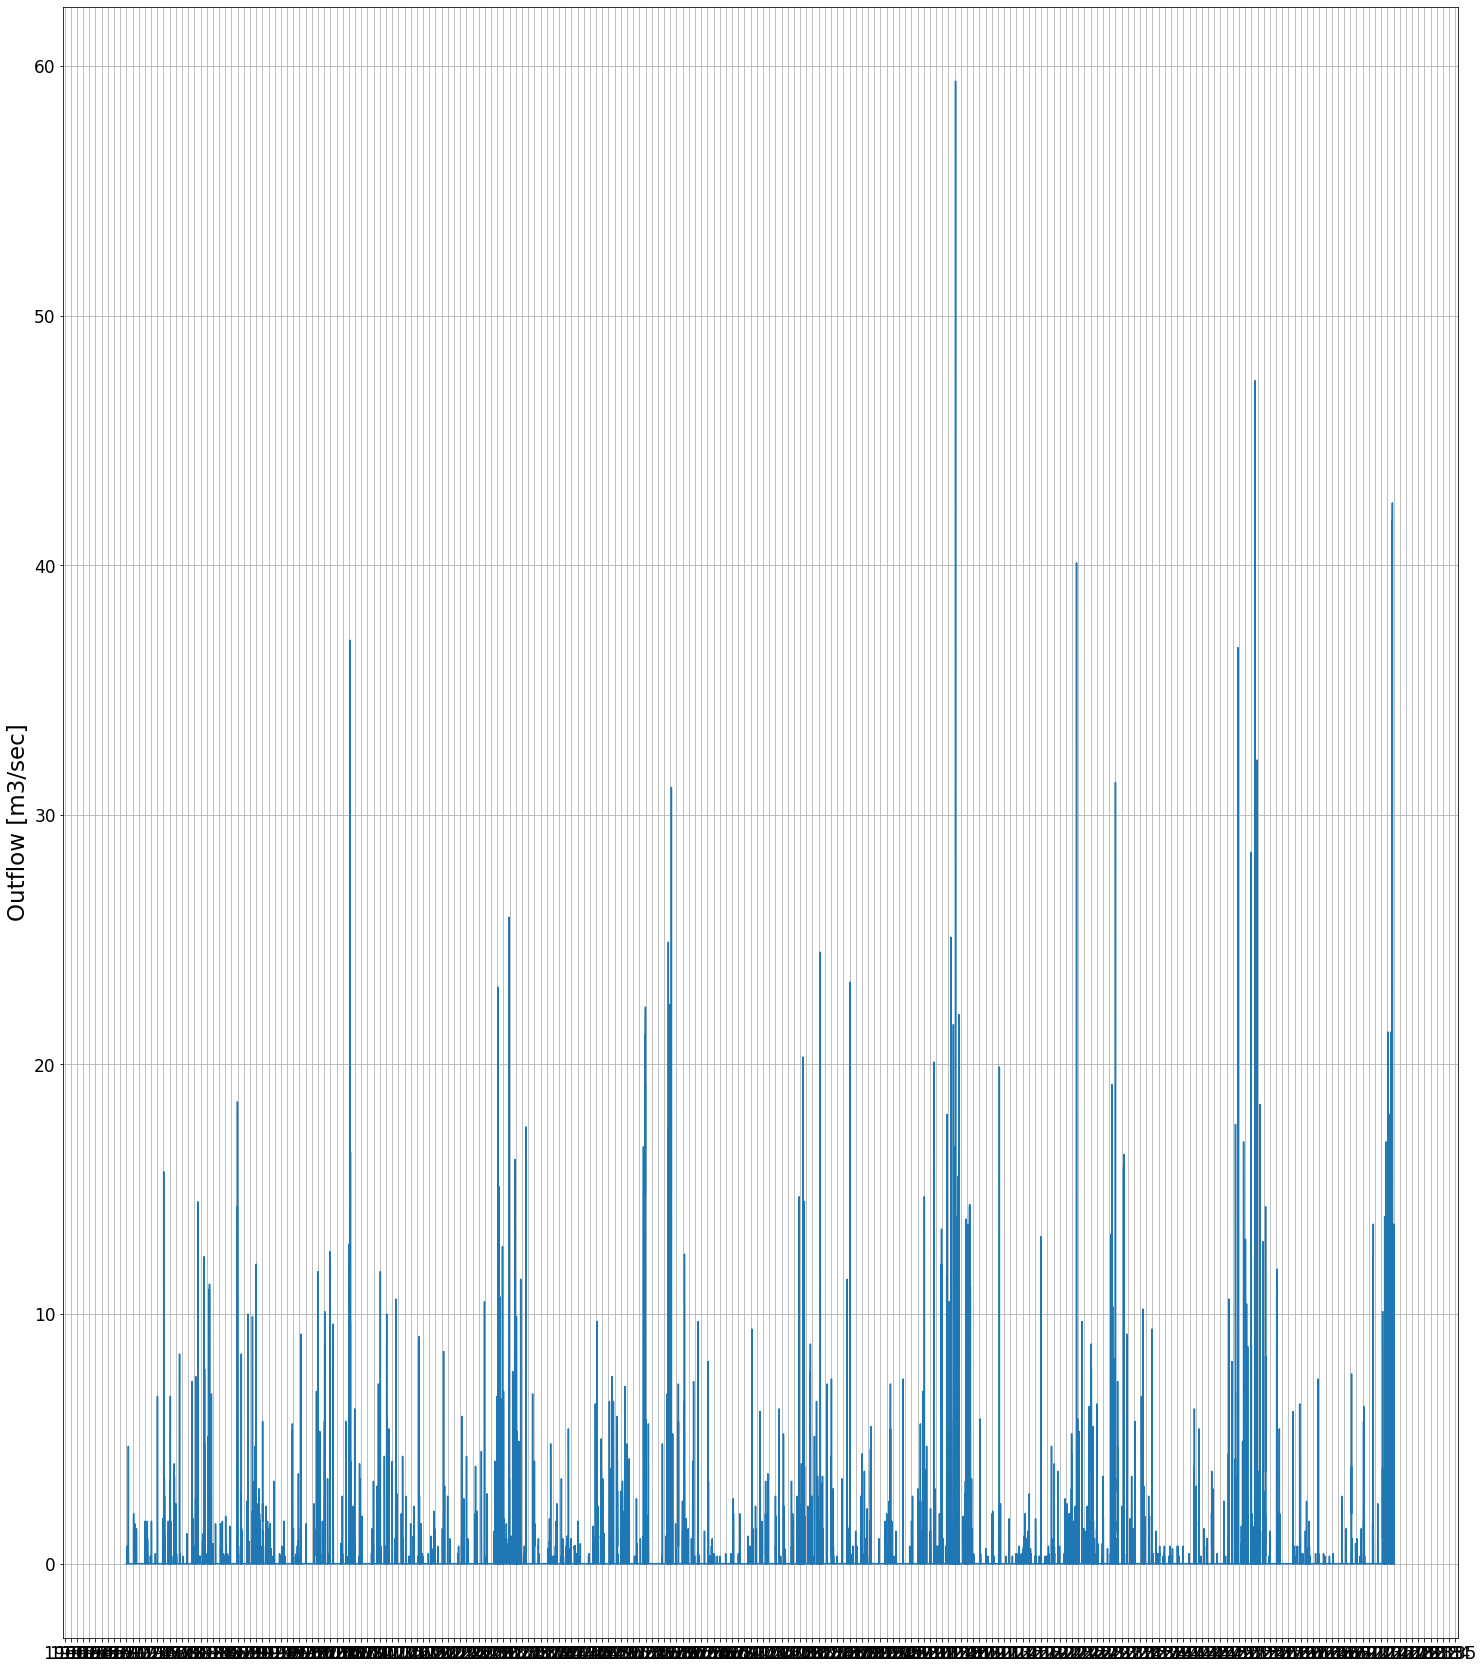

In [9]:
# 데이터 시각화 

plt.figure(figsize=(25,30))

dam_o = sns.lineplot(data=raw_df['rainfall'])
plt.ylabel('Outflow [m3/sec]',fontsize =23)
plt.xticks(fontsize =17)
plt.yticks(fontsize =17)
plt.grid(True)  
dam_o.xaxis.set_major_locator(mdates.YearLocator())
dam_o.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#### 기존에 존재하던 feature들

In [10]:
features = raw_df[feature_cols]
print(features)

       rainfall  inflow  outflow  reserve_rate
0           0.0     2.6      2.6          45.3
1           0.0     3.0      3.0          45.3
2           0.0     3.1      3.1          45.3
3           0.0     3.0      3.0          45.3
4           0.0     2.9      2.9          45.3
...         ...     ...      ...           ...
74932       0.0    21.3     34.3          61.1
74933       0.0    21.8     33.9          61.1
74934       0.0    20.5     33.7          61.0
74935       0.0    21.8     34.0          61.0
74936       0.0    20.6     34.0          60.9

[74929 rows x 4 columns]


#### NewFeatures

##### Lag_Features, Window_Features

- 지연(lag) feature: 이전 시간 단위의 데이터를 사용하는 것이 유용할 수 있을 것이다. 예를 들어 1시간 전, 3시간 전, 12시간 전 등의 댐 수위, 강우량, 유입량, 총 방류량, 저수량 등
댐 수위, 강우량, 유입량, 총 방류량, 저수량의 1시간, 3시간, 24시간 평균/최대/최소 등

- 이 feature들을 사용하면, 12시간의 평균을 내야 하기 때문에, 앞의 1, 3, 12시간은 NaN으로 나타난다. (조정 가능, 임의로 3개를 만들어둠) 따라서 forecasting timescope를 2015-01-01 13:00 부터 사용할 수 있음.

In [84]:
# 설정할 lag 단위를 만들어둠
lags = [1, 3, 12]

# 새로운 lag feature 생성
for lag in lags:
    chungju_hr_df[f'water_level_lag{lag}'] = chungju_hr_df['water_level'].shift(lag)
    chungju_hr_df[f'rainfall_lag{lag}'] = chungju_hr_df['rainfall'].shift(lag)
    chungju_hr_df[f'inflow_lag{lag}'] = chungju_hr_df['inflow'].shift(lag)
    chungju_hr_df[f'outflow_lag{lag}'] = chungju_hr_df['outflow'].shift(lag)
    chungju_hr_df[f'reserve_lag{lag}'] = chungju_hr_df['reserve'].shift(lag)

# 이동평균, 최대, 최소 feature 생성, 설정할 window 단위를 만들어둠
windows = [1, 3, 12]
for window in windows:
    chungju_hr_df[f'water_level_avg{window}'] = chungju_hr_df['water_level'].rolling(window).mean()
    chungju_hr_df[f'water_level_max{window}'] = chungju_hr_df['water_level'].rolling(window).max()
    chungju_hr_df[f'water_level_min{window}'] = chungju_hr_df['water_level'].rolling(window).min()
    # 위와 같은 방식으로 강우량, 유입량, 총 방류량, 저수량에 대한 이동평균, 최대, 최소를 계산할 수 있음,
    
chungju_hr_df

,date,water_level,rainfall,inflow,outflow,reserve,reserve_rate,water_level_lag1,rainfall_lag1,inflow_lag1,...,reserve_lag12,water_level_avg1,water_level_max1,water_level_min1,water_level_avg3,water_level_max3,water_level_min3,water_level_avg12,water_level_max12,water_level_min12
0,2015-01-01 01:00:00,126.21,0.0,482.4,0.0,1165.03,42.4,NaN,NaN,NaN,...,NaN,126.21,126.21,126.21,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 02:00:00,126.20,0.0,0.0,0.0,1164.45,42.3,126.21,0.0,482.4,...,NaN,126.20,126.20,126.20,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 03:00:00,126.19,0.0,0.0,0.0,1163.87,42.3,126.20,0.0,0.0,...,NaN,126.19,126.19,126.19,126.200000,126.21,126.19,NaN,NaN,NaN
3,2015-01-01 04:00:00,126.20,0.0,160.8,0.0,1164.45,42.3,126.19,0.0,0.0,...,NaN,126.20,126.20,126.20,126.196667,126.20,126.19,NaN,NaN,NaN
4,2015-01-01 05:00:00,126.22,0.0,321.8,0.0,1165.61,42.4,126.20,0.0,160.8,...,NaN,126.22,126.22,126.22,126.203333,126.22,126.19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74933,2023-07-20 06:00:00,130.93,0.0,585.4,771.4,1453.60,52.9,130.94,0.0,581.7,...,1459.82,130.93,130.93,130.93,130.940000,130.95,130.93,130.972500,131.01,130.93
74934,2023-07-20 07:00:00,130.92,0.0,590.0,771.0,1452.95,52.8,130.93,0.0,585.4,...,1459.50,130.92,130.92,130.92,130.930000,130.94,130.92,130.965000,131.01,130.92
74935,2023-07-20 08:00:00,130.90,0.0,522.7,771.2,1452.05,52.8,130.92,0.0,590.0,...,1459.09,130.90,130.90,130.90,130.916667,130.93,130.90,130.955833,131.00,130.90
74936,2023-07-20 09:00:00,130.89,0.0,542.7,774.2,1451.22,52.8,130.90,0.0,522.7,...,1458.73,130.89,130.89,130.89,130.903333,130.92,130.89,130.946667,130.99,130.89


##### Ratio Feature

- 유입량 대비 방류량 , 저수량 대비 방류량, 강우량 대비 유입량 등을 이용할 수 있을 것임.

- 유입량 변화량 대비 방류량 변화량, 저수량 변화량 대비 방류량 변화랑, 강우량 변화량 대비 방류량 변화량 등과 같이 이용하는 것이 더 좋을지는 예측 성능을 비교하여 결정할 예정임.

- 현재 견해로는 사실 아래 (~변화량 대비 ~변화량) feature를 이용하는 것이 더 좋을 것 같은데, 일단은 ~ 대비 ~ feature로 first training을 해보겠음.


In [ ]:
# 분모가 0인 경우 NaN으로 처리
chungju_hr_df['ratio_outflow_inflow'] = chungju_hr_df['outflow'] / chungju_hr_df['inflow'].replace(0, np.nan) #유입량 대비 방류량
chungju_hr_df['ratio_storage_quantity_discharge'] = chungju_hr_df['storage_quantity'] / chungju_hr_df['discharge'].replace(0, np.nan)
chungju_hr_df['ratio_fall_inflow'] = chungju_hr_df['fall'] / chungju_hr_df['inflow'].replace(0, np.nan)

In [85]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [87]:
preds_df_fin_xgb = pd.DataFrame()
smapes_df_fin_xgb = pd.DataFrame()